<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Regularisation and Text Classification</h2>
<br>

Sentiment analysis is the task of classifying text documents according to the sentiment expressed by the author. Sentiment analysis has several applications in areas such as marketing, where online comments, reviews, and messages provide a wealth of data about customers that can be leveraged towards improving brand and customer relationship management strategies. 

One approach this problem is to use a [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) model. In a bag of words model, we represent the document as a numerical vector where each element counts how many times a word (or sequence of words) appears in the document, or simply whether the word appears in the text (leading to a binary vector).  This is a substantial simplification this method disregards the linguistic structure of the document and context around the words. 

<a href="#1.-Twitter-airline-sentiment-data">Twitter airline sentiment data</a> <br>
<a href="#2.-NLP-with-spaCy">NLP with spaCy</a> <br>
<a href="#3.-Text-processing">Text processing</a> <br>
<a href="#4.-Train-test-split">Train-test split</a> <br>
<a href="#5.-Some-EDA">Some EDA</a> <br>
<a href="#6.-Feature-engineering">Feature engineering</a> <br>
<a href="#8.-Logistic-regression">Logistic regression</a> <br>
<a href="#9.-Model-stacking">Model stacking</a> <br>
<a href="#10.-Model-selection">Model selection</a> <br>
<a href="#11.-Model-evaluation">Model evaluation</a> <br>
<a href="#12.-Inference">Inference</a> <br>

This notebook relies on the following imports and settings.

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score

# 1. Twitter airline sentiment data

In this tutorial, we use the [Twitter Arline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) dataset assembled by a company called [Crowdflower](https://www.crowdflower.com/) and made available [Kaggle datasets](https://www.kaggle.com/datasets) page. To build this dataset, the data scientists at Crowdflower scraped all tweets addressed at US airlines in the month of February 2015, including metadata about the message. Human contributors then categorised each tweet according to the sentiment (positive, neutral, or negative) expressed by the user, which can be done through services like [Amazon Mechanical Turk](https://www.mturk.com/).

In [5]:
data=pd.read_csv('Data/Tweets.csv')
data.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In sentiment analysis, it is common to use hierarchical classifiers that first classify a document as expressing a neutral or non-neutral sentiment, and then classify the sentiment in the documents that are predicted to have polarity. Therefore, we simplify our analysis to consider only positive and negatives tweets. Furthermore, we only keep the tweets that were classified with full confidence by the human labellers. 

In [6]:
data=data[data['airline_sentiment']!='neutral']
data=data[data['airline_sentiment_confidence']==1.0]

The filtered dataset has 8897 observations.

In [7]:
len(data)

8897

Our objective to build a classifier that achieves maximum accuracy in distinguishing between positive and negative sentiment.

In [8]:
data['positive']=(data['airline_sentiment']=='positive').astype(int)

Here are examples of negative and positive tweets.

In [9]:
data.loc[4126, 'text']

'@united stuck here in IAH waiting on flight 253 to Honolulu for 7 hours due to maintenance issues. Could we have gotten a new plane!?!? Fail'

In [10]:
data.loc[8644, 'text']

'@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!'

# 2. NLP with spaCy

[SpaCy](https://spacy.io/) is an excellent library for natural language processing that will be helpful in this tutorial.

To get started, we important the package and load a trained English language pipeline. 

In [13]:
import spacy
nlp = spacy.load('en_core_web_sm') # use en_core_web_sm if you have installation problems

We can then use the `nlp` object process text. Here are some of the things that spaCy does:

* Tokenization: splitting the text into individual words and punctuation marks.
* Part-of-speech (POS) tagging: assigning part-of-speech labels (such noun, verb, adjective, etc) to each token. 
* Dependency parsing: assigning syntactic dependency labels (such as subject and objective).
* Named entity recognition (NER): find and classify named entities (people, organisations) in the text. 
* Lemmatisation: assigning the base form of words.

In [14]:
doc = nlp('Had a great flight to Sydney from Singapore a few weeks ago!')

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.is_alpha, token.is_stop)
    
# Text: The original word text.
# Lemma: The base form of the word.
# POS: simple part-of-speech tag.
# Tag: detailed part-of-speech tag.
# Dep: syntactic dependency.
# is alpha: Is the token an alpha character?
# is stop: Is the token part of a stop list, i.e. the most common words of the language?

Had have VERB VBD ROOT True True
a a DET DT det True True
great great ADJ JJ amod True False
flight flight NOUN NN dobj True False
to to ADP IN prep True True
Sydney Sydney PROPN NNP pobj True False
from from ADP IN prep True True
Singapore Singapore PROPN NNP pobj True False
a a DET DT det True True
few few ADJ JJ amod True True
weeks week NOUN NNS npadvmod True False
ago ago ADV RB advmod True False
! ! PUNCT . punct False False


You can use the `explain` function to understand the tags.

In [15]:
spacy.explain('PROPN')

'proper noun'

You can use `displacy` to visualise the dependencies. 

In [16]:
from spacy import displacy

displacy.render(doc, style="dep", jupyter=True)

There's also a useful visualisation of named entities.

In [17]:
displacy.render(doc, style="ent", jupyter=True)

Before continuing, we disable the parts of the text processing pipeline that we won't need to speed things up.

In [19]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# 3. Text processing

Text analysis requires careful processing of the raw text data to convert documents into a format that is amenable to machine learning. We implement four main processing steps: 

<ol style="margin-left: -10px">
  <li style="margin-top: 12px;"> Tokenisation: separate the text into tokens (words) for a bag of words representation.</li>
  <li style="margin-top: 12px;">Lemmatisation: converting words into base form. Say, it can be more useful to consider "democracy", "democracies", "democratic", and "democratization" as the same token.</li>
  <li style="margin-top: 12px;">Removing uninformative punctuation.</li>
  <li style="margin-top: 12px;">Removing stopwords (uninformative words such as "the" and "to").</li>
</ol>

It's instructive to illustrate each of these steps. First, we convert the text into lower case tokens.

In [20]:
tweet=data.loc[8644, 'text'] 
doc = nlp(tweet)
tokenized = [token.lower_ for token in doc]

print('Original:')
print(tweet)
print('\nTokenised:')
print(tokenized)

Original:
@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!

Tokenised:
['@jetblue', 'had', 'a', 'great', 'flight', 'to', 'orlando', 'from', 'hartford', 'a', 'few', 'weeks', 'ago', '!', 'was', 'great', 'to', 'get', 'out', 'on', 'time', 'and', 'arrive', 'early', '!']


SpaCy does lemmatisation automatically, so we just have to retrieve the `lemma_` attribute instead and convert the result to lower case.

In [21]:
tokenized = [token.lemma_.lower() for token in doc]

print('Original:')
print(tweet)
print('\nTokenised, lemmas:')
print(tokenized)

Original:
@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!

Tokenised, lemmas:
['@jetblue', 'have', 'a', 'great', 'flight', 'to', 'orlando', 'from', 'hartford', 'a', 'few', 'week', 'ago', '!', 'be', 'great', 'to', 'get', 'out', 'on', 'time', 'and', 'arrive', 'early', '!']


Now, we modify the code to filter out the stopwords.

In [22]:
tokenized = [token.lemma_.lower() for token in doc if not token.is_stop]

print('Original:')
print(tweet)
print('\nTokenised, lemmatised, no stopwords:')
print(tokenized)

Original:
@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!

Tokenised, lemmatised, no stopwords:
['@jetblue', 'great', 'flight', 'orlando', 'hartford', 'week', 'ago', '!', 'great', 'time', 'arrive', 'early', '!']


We can also add a condition to filter out punctuation.

In [23]:
tokenized = [token.lemma_.lower() for token in doc if not (token.is_stop or token.is_punct)]

print('Original:')
print(tweet)
print('\nTokenised, lemmatised, no stopwords, no punctuation:')
print(tokenized)

Original:
@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!

Tokenised, lemmatised, no stopwords, no punctuation:
['@jetblue', 'great', 'flight', 'orlando', 'hartford', 'week', 'ago', 'great', 'time', 'arrive', 'early']


We write a function to do all the desired processing.  

We add a few details such as creating special tokens for emojis and numbers. Understanding some parts of the code requires basic knowledge of regular expressions, don't worry about these parts.

In [24]:
import re 

def tokenizer(text):
    
    # Replace emojis with special tokens
    text = re.sub(r'[❤💕💗💜💖💘💙💝😍]', ' xxheart ', text)
    text = re.sub(r'[😀😉😄😎😊😁🌞☺]', ' xxsmile ', text) 
    text = re.sub(r'[😢😔😭😞😪😕😓😩😦]', ' xxsadface ', text) 
    text = re.sub(r'[😋😜]', ' xxlolface ', text) 
    
    # Replace urls with a special token
    text = re.sub('https?\S+', 'xxurl', text) 
    text = re.sub('\S*www[.]\S+', 'xxurl', text)

    # Replace emoticons with special tokens
    text = re.sub(r'<3', 'xxheart', text) 
    text = re.sub(r'&lt;3', 'xxheart', text)
    
    eyes = r'[8:=;]'
    nose = r'[\'`-]*'
    text = re.sub(eyes + nose + r'[)D]+', 'xxsmile', text)
    text = re.sub(eyes + nose + r'[(]+', 'xxsadface', text)
    text = re.sub(eyes + nose + r'p+', 'xxlolface', text)
    text = re.sub(eyes + nose + r'[|/\\]+', 'xxneutralface', text)

    # Creating a special token for hashtags
    text = re.sub(r'#(\S+)', 'xxhashtag ' + r'\1', text) # hashtag
    
    # Stripping repeated whitespace
    text = re.sub(r'\s{2,}', ' ', text)
    
    doc = nlp(text)
    
    tokens = []
    
    for token in doc: 
        
        word = token.lemma_.lower()
        
        if not token.is_stop:
            
            if word == '!': 
                tokens.append('!') 
                            
            elif token.like_num:
                tokens.append('xxnumber')
                
            elif (not token.is_punct) and word != '️':
                tokens.append(word)
                
    return tokens

Let's test the function.

In [25]:
text = data.loc[18, 'text']
tokens = tokenizer(text)

print(text)
print(tokens)

I ❤️ flying @VirginAmerica. ☺️👍
['xxheart', 'fly', '@virginamerica', 'xxsmile', '👍']


One limitation of our approach is that spaCY is designed for processing regular text, not tweets.

# 4. Train-test split

Let's split the data into training and test sets before continuing. 

In [26]:
# Only keeping the columns that we'll use
data=data[['airline','text', 'airline_sentiment','positive']]

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, 
                                            random_state=1, stratify=data['positive'])

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()


y_train = train['positive'].to_numpy()
y_test = test['positive'].to_numpy()

# 5. Some EDA


## 5.1 Response variable 

83% of the tweets are negative and 17% are positive.

In [27]:
train['airline_sentiment'].value_counts()

negative    5167
positive    1060
Name: airline_sentiment, dtype: int64

In [28]:
train['airline_sentiment'].value_counts(normalize=True).round(3)

negative    0.83
positive    0.17
Name: airline_sentiment, dtype: float64

## 5.2 Word clouds 

We build word clouds for positive and negative tweets.

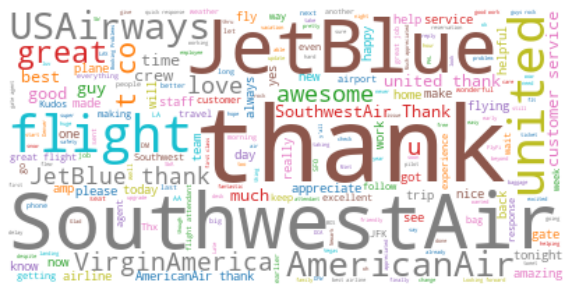

In [29]:
positive_tweets = train[train['airline_sentiment']=='positive']['text']
positive_tweets = ' '.join(positive_tweets)

from wordcloud import WordCloud

fig, ax = plt.subplots(figsize=(10,8))
wordcloud = WordCloud(background_color="white", colormap='tab10', max_words=200).generate(positive_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

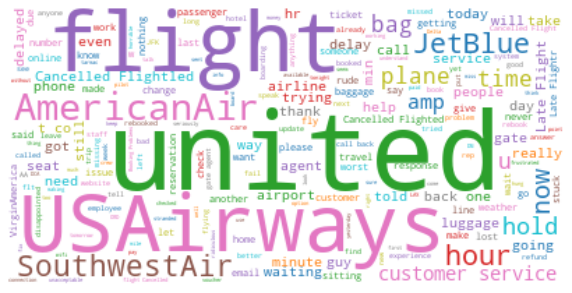

In [30]:
negative_tweets = train[train['airline_sentiment']=='negative']['text']
negative_tweets = ' '.join(negative_tweets)

from wordcloud import WordCloud

fig, ax = plt.subplots(figsize=(10,8))
wordcloud = WordCloud(background_color="white", colormap='tab10', max_words=200).generate(negative_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 5. Feature engineering

As mentioned in the introduction, we will build a bag of words representation. Each feature will be a dummy variable indicating the presence of a token in a tweet. 

Fortunately, the `scikit-learn` package makes things easy for us. We just have to pass the customer tokenizer that we coded above. The `min_df=5` option means that we a token needs to appear in at least five tweets to be considered.

In [31]:
%%time 

# This may take a minute to run

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=False, tokenizer=tokenizer, min_df=5, binary=True)
X_train = vectorizer.fit_transform(train['text'])
X_test = vectorizer.transform(test['text'])

Wall time: 17.8 s


We have 1331 features. 

In [32]:
X_train.shape

(6227, 1330)

It's useful to retrieve the tokens that correspond to each feature. 

In [33]:
feature_names = vectorizer.get_feature_names()

This week's practice will ask you to experiment with feature engineering variations.  

# 6. Logistic regression

We start by fitting a logistic regression without regularisation as a benchmark. 

In [34]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(penalty='none')
logit.fit(X_train, y_train)

LogisticRegression(penalty='none')

Regularisation will be probably be helpful there is a large number of features. We use the [<TT>LogisticRegressionCV<TT>](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) class, which has built-in grid search for hyperparameter optimisation 

In [35]:
from sklearn.linear_model import LogisticRegressionCV
logit_l1= LogisticRegressionCV(penalty='l1', solver='liblinear', scoring='neg_log_loss')
logit_l1.fit(X_train, y_train)

LogisticRegressionCV(penalty='l1', scoring='neg_log_loss', solver='liblinear')

L1 regularisation sets more than half of the coefficients to zero. 

In [36]:
np.sum(np.abs(logit_l1.coef_) == 0.0)

737

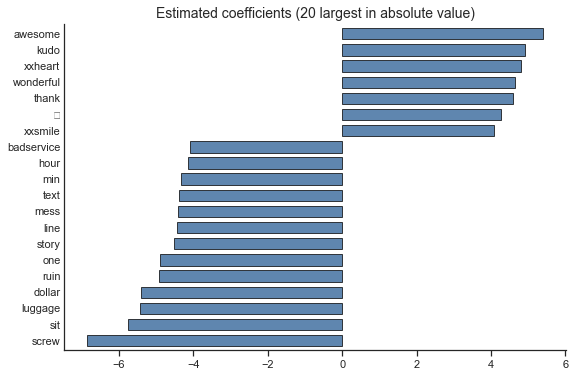

In [37]:
# Re-using the auxiliary code from Tutorial 4
from tutorial4 import coefplot
coefplot(logit_l1, feature_names)
plt.show()

The code for L2 regularisation is almost the same.

In [38]:
logit_l2= LogisticRegressionCV(Cs = 50, penalty='l2', solver='lbfgs', scoring='neg_log_loss')
logit_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=50, scoring='neg_log_loss')

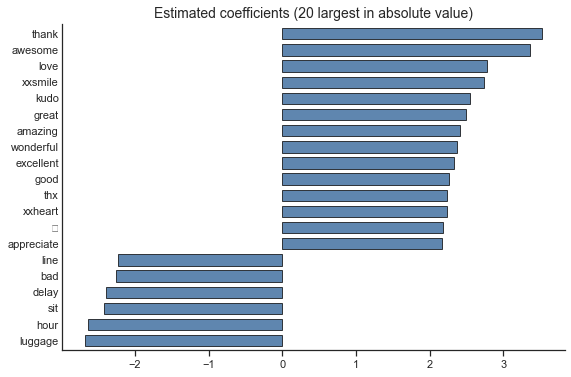

In [39]:
coefplot(logit_l2, feature_names)
plt.show()

You can also do elastic net regularisation as follows, but we skip this here as it's quite slow. 

In [40]:
# logit_enet = LogisticRegressionCV(Cs = 25, penalty='elasticnet', l1_ratios = [0.25, 0.5, 0.75],
#                                  solver='saga', scoring='neg_log_loss')
# logit_enet.fit(X_train, y_train)

# 7. Model stacking

The Naive Bayes classifier, which you may have learned about in a previous unit, is a standard method for text classification.  Let's include it here so that we have some diversity in our models.

In [41]:
from sklearn.naive_bayes import BernoulliNB
nbc = BernoulliNB() # this class only applies when all the predictors are binary, don't use it otherwise
nbc.fit(X_train, y_train)

BernoulliNB()

It's worth checking if we can improve accuracy by ensembling the logistic regression and Naive Bayes methods.  

In [42]:
from sklearn.ensemble import StackingClassifier

## Ideal, but slow: nested CV to select the regularisation penalty
# estimators = [
#     ('logit',  LogisticRegressionCV(Cs = 50, penalty='l2', solver='lbfgs', scoring='neg_log_loss')),
#     ('nbc', BernoulliNB())
# ]

estimators = [
    ('logit',  LogisticRegression(C=logit_l2.C_[0], penalty='l2', solver='lbfgs')),
    ('nbc', BernoulliNB())
]


stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(penalty='none'))
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('logit',
                                LogisticRegression(C=1.7575106248547894)),
                               ('nbc', BernoulliNB())],
                   final_estimator=LogisticRegression(penalty='none'))

I don't find this implementation ideal since the inputs to the meta-model are predicted probabilities. Because the meta-model is a logistic regression, it would make more sense if the inputs were the logits of the predicted probabilities. Unfortunately, I do not know of a Python implementation that does this. In practice, I'd prefer fit the stack manually.

# 8. Model selection

Let's use (nested) cross-validation to compare the performance of all the previous methods and select our final model. 

The results show that the regularisation is essential in this application.

We select the model stack as the final model since it has the lowest cross-validation error. 

In [43]:
%%time

from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss

columns=['Error rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Naive Bayes', 'Logistic', 'Logistic $\ell_1$', 'Logistic $\ell_2$', 'Stack']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[nbc, logit, logit_l1, logit_l2, stack]

y_prob = np.zeros((len(train), len(rows))) 

for i, method in enumerate(methods):

    y_prob[:, i] = cross_val_predict(method, X_train, y_train, method='predict_proba')[:, 1]        
    y_pred = (y_prob[:, i] > 0.5).astype(int)
    
    
    confusion  = confusion_matrix(y_train, y_pred) 
    results.iloc[i,0]=  1 - accuracy_score(y_train, y_pred)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,3]=  precision_score(y_train, y_pred)
    results.iloc[i,4]=  roc_auc_score(y_train, y_prob[:,i])   
    results.iloc[i,5]=  log_loss(y_train, y_prob[:,i])   

results.round(3)

Wall time: 27.9 s


,Error rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Naive Bayes,0.053,0.854,0.966,0.836,0.972,0.156
Logistic,0.074,0.831,0.946,0.758,0.944,2.225
Logistic $\ell_1$,0.057,0.812,0.970,0.847,0.971,0.162
Logistic $\ell_2$,0.051,0.802,0.979,0.888,0.976,0.139
Stack,0.047,0.825,0.979,0.890,0.976,0.139


# 9. Model evaluation

Remember that the goal of model evaluation is to estimate the performance of the final model.

It's useful to have a benchmark for model evaluation. Here, we a prediction rule that classifies all messages as negative. Because most tweets are negative, that automatically leads to an accuracy of 83% for classification, which is then what we are trying to improve on.

In [44]:
columns=['Error rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['All negative', 'Stack']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[None, stack]

y_prob = np.zeros((len(test), len(rows))) # we'll store the probabilities for later

for i, method in enumerate(methods):
    
    if i==0: # all negative
        y_pred = np.zeros(len(y_test))
        y_prob[:, i] = np.mean(y_train)
    else:
        y_pred = method.predict(X_test)
        y_prob[:, i] = method.predict_proba(X_test)[:,1]
    

    confusion  = confusion_matrix(y_test, y_pred) 
    results.iloc[i,0]=  1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,3]=  precision_score(y_test, y_pred)
    results.iloc[i,4]=  roc_auc_score(y_test, y_prob[:,i])   
    results.iloc[i,5]=  log_loss(y_test, y_prob[:,i])   

results.round(3)

,Error rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy
All negative,0.170,0.000,1.000,0.0,0.500,0.457
Stack,0.045,0.829,0.981,0.9,0.978,0.130


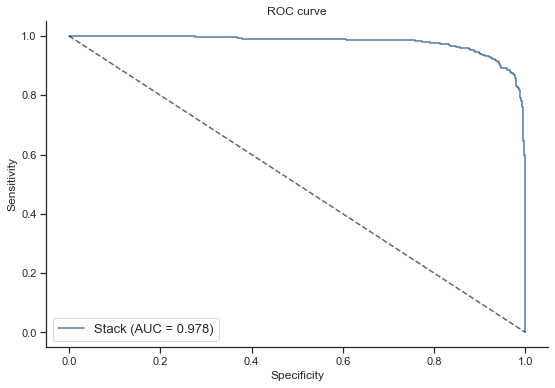

In [45]:
from tutorial4 import rocplot

fig, ax = rocplot(y_test, y_prob[:,1].reshape((-1,1)), labels=pd.Series(rows[-1]))
ax.set_title('ROC curve')
plt.show()

# 10. Inference

Recall inference means to use a model for prediction in machine learning. Let's build a function to do that. 

First, we configure a SHAP explainer for interpretation (don't worry about the code).

In [47]:
import shap
shap.initjs()

def predict(x):
    p = stack.predict_proba(x)[:, 1]
    return np.log(p/(1-p))

X_train_summary = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(predict, X_train_summary)

We the write the inference function. 

In [48]:
def classify(text):
    features = vectorizer.transform([text])
    prob = stack.predict_proba(features)[0, 1]
    
    if prob>=0.5:
        print(f'The predicted sentiment is positive with probability {(100*prob):.1f}%.')
    else:
         print(f'The predicted sentiment is negative with probability {(100*(1-prob)):.1f}%.')
            
    shap_values = explainer.shap_values(features, silent = True)
    p = shap.force_plot(explainer.expected_value, shap_values[0], feature_names = feature_names)
    display(p)

In [49]:
classify('My flight was terrible, the airline lost my luggage.')

The predicted sentiment is negative with probability 98.6%.


In [50]:
classify('My flight was absolutely wonderful, there were many films to watch!')

The predicted sentiment is positive with probability 84.9%.
